In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [3]:
torch.manual_seed(1)

# 소프트맥스의 비용 함수 구현 (로우-레벨)

In [4]:
z = torch.FloatTensor([1, 2, 3])

In [5]:
hypothesis = F.softmax(z, dim = 0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [7]:
hypothesis.sum()

tensor(1.)

In [8]:
z = torch.rand(3, 5, requires_grad = True)
hypothesis = F.softmax(z, dim = 1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [9]:
y = torch.randint(5, (3, )).long()
print(y)

tensor([0, 2, 1])


In [10]:
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [11]:
print(y.unsqueeze(1))

tensor([[0],
        [2],
        [1]])


In [12]:
print(y_one_hot)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])


In [13]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim = 1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


# 소프트맥스의 비용 함수 구현 (하이-레벨)

In [14]:
# Low level
torch.log(F.softmax(z, dim = 1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [15]:
# High level
F.log_softmax(z, dim = 1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [16]:
# Low level, 첫 번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim = 1))).sum(dim = 1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [17]:
# Low level, 두 번째 수식
(y_one_hot * -F.log_softmax(z, dim = 1)).sum(dim = 1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [18]:
# High level, 세 번째 수식
F.nll_loss(F.log_softmax(z, dim = 1), y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

In [19]:
# High level, 네 번째 수식
F.cross_entropy(z, y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

# 소프트맥스 회귀 구현해보기 (로우-레벨)

In [20]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [21]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [22]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


In [23]:
W = torch.zeros((4, 3), requires_grad = True)
b = torch.zeros(1, requires_grad = True)
optimizer = optim.SGD([W, b], lr = 0.1)

In [24]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  #hypothesis
  hypothesis = F.softmax(x_train.matmul(W) + b, dim = 1)

  #cost
  cost = (y_one_hot * -torch.log(hypothesis)).sum(dim = 1).mean()

  #cost로 H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  
  # 100번마다 로그 출력
  if epoch % 100 == 0:
    print('Epoch {:4d} / {} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0 / 1000 Cost: 1.098612
Epoch  100 / 1000 Cost: 0.761050
Epoch  200 / 1000 Cost: 0.689991
Epoch  300 / 1000 Cost: 0.643229
Epoch  400 / 1000 Cost: 0.604117
Epoch  500 / 1000 Cost: 0.568255
Epoch  600 / 1000 Cost: 0.533922
Epoch  700 / 1000 Cost: 0.500291
Epoch  800 / 1000 Cost: 0.466908
Epoch  900 / 1000 Cost: 0.433507
Epoch 1000 / 1000 Cost: 0.399962


# 소프트맥스 회귀 구현해보기 (하이-레벨)

In [25]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad = True)
b = torch.zeros(1, requires_grad = True)
                
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  # cost 계산
  z = x_train.matmul(W) + b
  cost = F.cross_entropy(z, y_train)

  # cost로 H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  # 100번마다 로그 출력
  if epoch % 100 == 0:
    print('Epoch {:4d} / {} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0 / 1000 Cost: 1.098612
Epoch  100 / 1000 Cost: 0.761050
Epoch  200 / 1000 Cost: 0.689991
Epoch  300 / 1000 Cost: 0.643229
Epoch  400 / 1000 Cost: 0.604117
Epoch  500 / 1000 Cost: 0.568256
Epoch  600 / 1000 Cost: 0.533922
Epoch  700 / 1000 Cost: 0.500291
Epoch  800 / 1000 Cost: 0.466908
Epoch  900 / 1000 Cost: 0.433507
Epoch 1000 / 1000 Cost: 0.399962


# 소프트맥스 회귀 구현해보기 (nn.Module)

In [26]:
model = nn.Linear(4, 3)

In [27]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr = 0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

  # H(x) 계산
  prediction = model(x_train)

  # cost 계싼
  cost = F.cross_entropy(prediction, y_train)

  # cost로 H(x) 계산
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  # 100번마다 로그 출력
  if epoch % 100 == 0:
    print('Epoch {:4d} / {} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0 / 1000 Cost: 1.849513
Epoch  100 / 1000 Cost: 0.689894
Epoch  200 / 1000 Cost: 0.609259
Epoch  300 / 1000 Cost: 0.551218
Epoch  400 / 1000 Cost: 0.500141
Epoch  500 / 1000 Cost: 0.451947
Epoch  600 / 1000 Cost: 0.405051
Epoch  700 / 1000 Cost: 0.358733
Epoch  800 / 1000 Cost: 0.312912
Epoch  900 / 1000 Cost: 0.269522
Epoch 1000 / 1000 Cost: 0.241922


# 소프트맥스 회귀 구현해보기 (회귀 클래스)

In [28]:
class SoftmaxClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(4, 3)

  def forward(self, x):
    return self.linear(x)

In [29]:
model = SoftmaxClassifierModel()

In [41]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr = 0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  # H(x) 계산
  prediction = model(x_train)

  # cost 계산
  cost = F.cross_entropy(prediction, y_train)

  # cost로 H(x) 계산
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  # 100번마다 로그 출력
  if epoch % 100 == 0:
    print('Epoch {:4d} / {} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0 / 1000 Cost: 1.909684
Epoch  100 / 1000 Cost: 0.704585
Epoch  200 / 1000 Cost: 0.624996
Epoch  300 / 1000 Cost: 0.568276
Epoch  400 / 1000 Cost: 0.518170
Epoch  500 / 1000 Cost: 0.470783
Epoch  600 / 1000 Cost: 0.424618
Epoch  700 / 1000 Cost: 0.378954
Epoch  800 / 1000 Cost: 0.333507
Epoch  900 / 1000 Cost: 0.288837
Epoch 1000 / 1000 Cost: 0.250643


# 소프트맥스 회귀로 MNIST 데이터 분류하기

In [30]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다: ", device)

다음 기기로 학습합니다:  cuda


In [31]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [32]:
training_epochs = 15
batch_size = 100

In [35]:
mnist_train = dsets.MNIST(root = 'MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
mnist_test = dsets.MNIST(root = 'MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [36]:
data_loader = DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)

In [37]:
linear = nn.Linear(784, 10, bias = True).to(device)

In [38]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(linear.parameters(), lr = 0.1)

In [41]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for X, Y in data_loader:
    X = X.view(-1, 28 * 28).to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = linear(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  print('Epoch: ', '%04d' % (epoch + 1), 'Cost: ', '{:.9f}'.format(avg_cost))
print('Learning finished')

Epoch:  0001 Cost:  0.272274405
Epoch:  0002 Cost:  0.270824701
Epoch:  0003 Cost:  0.269695818
Epoch:  0004 Cost:  0.268577188
Epoch:  0005 Cost:  0.267852753
Epoch:  0006 Cost:  0.266824841
Epoch:  0007 Cost:  0.266019672
Epoch:  0008 Cost:  0.264925957
Epoch:  0009 Cost:  0.264252573
Epoch:  0010 Cost:  0.263517261
Epoch:  0011 Cost:  0.262637228
Epoch:  0012 Cost:  0.261978716
Epoch:  0013 Cost:  0.261342645
Epoch:  0014 Cost:  0.261048287
Epoch:  0015 Cost:  0.260449946
Learning finished


Accuracy:  0.8747999668121338
Label:  9
Prediction:  9


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


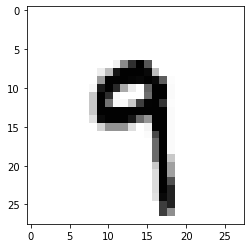

In [45]:
with torch.no_grad():
  X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = linear(X_test)
  correct_prediction = torch.argmax(prediction, 1) == Y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy: ', accuracy.item())

  r = random.randint(0, len(mnist_test) - 1)
  X_single_data = mnist_test.test_data[r: r + 1].view(-1, 28 * 28).float().to(device)
  Y_single_data = mnist_test.test_labels[r : r + 1].to(device)

  print('Label: ', Y_single_data.item())
  single_prediction = linear(X_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.test_data[r : r + 1].view(28, 28), cmap = 'Greys', interpolation = 'nearest')
  plt.show()